In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

Global seed set to 0
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:54: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  "pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6"
/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
condition_key = 'study'
cell_type_key = 'cell_type'

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [7]:
url = 'https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd'
output = 'pancreas.h5ad'
gdown.download(url, output, quiet=False)

Access denied with the following error:



 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1ehxgfHTsMZXy6YzlFKGJOsBKQ5rrvMnd 



In [8]:
adata_all = sc.read('pancreas.h5ad')

In [9]:
adata = adata_all.raw.to_adata()
# adata = sc.pp.subsample(adata, fraction=None, n_obs=1000, random_state=0, copy=True)
adata = remove_sparsity(adata)
source_adata = adata[adata.obs[condition_key].isin(['Pancreas CelSeq2'])]
source_conditions = source_adata.obs[condition_key].unique().tolist()
source_adata

View of AnnData object with n_obs × n_vars = 2426 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [10]:
adata_tasks = ['Pancreas CelSeq2','Pancreas CelSeq', 'Pancreas Fluidigm C1', 'Pancreas SS2','Pancreas inDrop'] #'Pancreas CelSeq2',

In [11]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
 )


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [12]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='latent replay',
)

latent replay is happening!
 |█████---------------| 28.0%  - val_loss: 770.5988159180 - val_recon_loss: 761.4173583984 - val_kl_loss: 13.2107567787 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |███████-------------| 36.8%  - val_loss: 768.5836791992 - val_recon_loss: 757.9710998535 - val_kl_loss: 11.5984253883 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 40.8%  - val_loss: 770.2385253906 - val_recon_loss: 758.8054809570 - val_kl_loss: 11.4330277443 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 42.2%  - val_loss: 766.9643249512 - val_recon_loss: 755.5591735840 - val_kl_loss: 11.4051446915 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 189


In [13]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

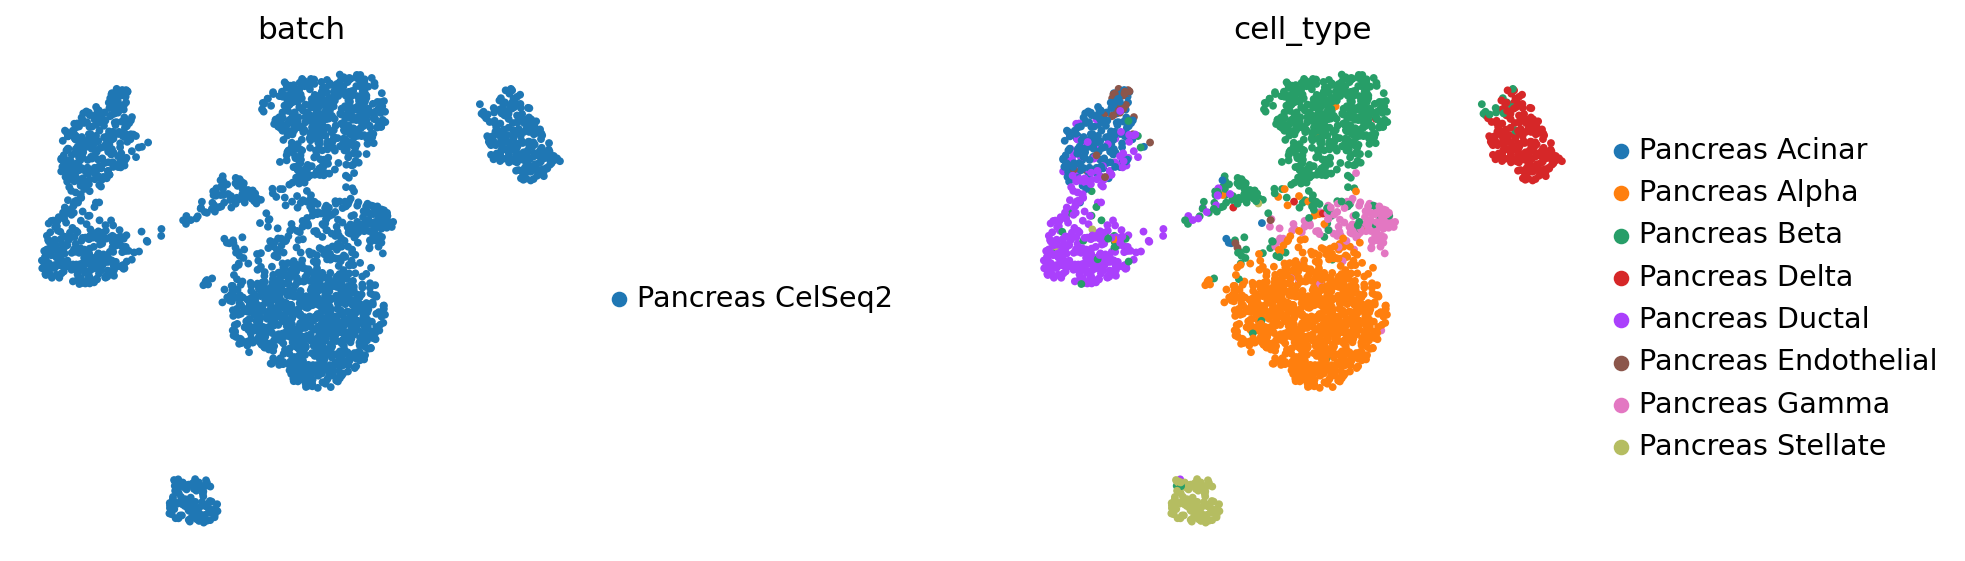

In [14]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [15]:
ref_path = 'reference_model/'
trvae.save(ref_path, overwrite=True)

In [16]:
for ID, task in enumerate(adata_tasks[1:], start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID)
    task_i = adata[adata.obs[condition_key].isin([task])]
    new_trvae = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'latent replay',
                                                 model=ref_path)
    new_trvae.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'latent replay'
    )
    
    ref_path = 'reference_model/'
    new_trvae.save(ref_path, overwrite=True)

1

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 1000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 

latent replay is happening!
 |██████--------------| 33.8%  - val_loss: 620.9351806641 - val_recon_loss: 603.4307250977 - val_kl_loss: 20.8386707306 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███████-------------| 39.2%  - val_loss: 620.7138671875 - val_recon_loss: 600.6594238281 - val_kl_loss: 20.5686588287 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████████------------| 40.6%  - val_loss: 619.3873291016 - val_recon_loss: 598.8417968750 - val_kl_loss: 20.5455169678 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State wa

In [17]:
surg_path = 'surgery_model'
new_trvae.save(surg_path, overwrite=True)

In [18]:
full_latent = sc.AnnData(new_trvae.get_latent(adata.X, adata.obs[condition_key]))
full_latent.obs['cell_type'] = adata.obs[cell_type_key].tolist()
full_latent.obs['batch'] = adata.obs[condition_key].tolist()
full_latent.obsm

AxisArrays with keys: 

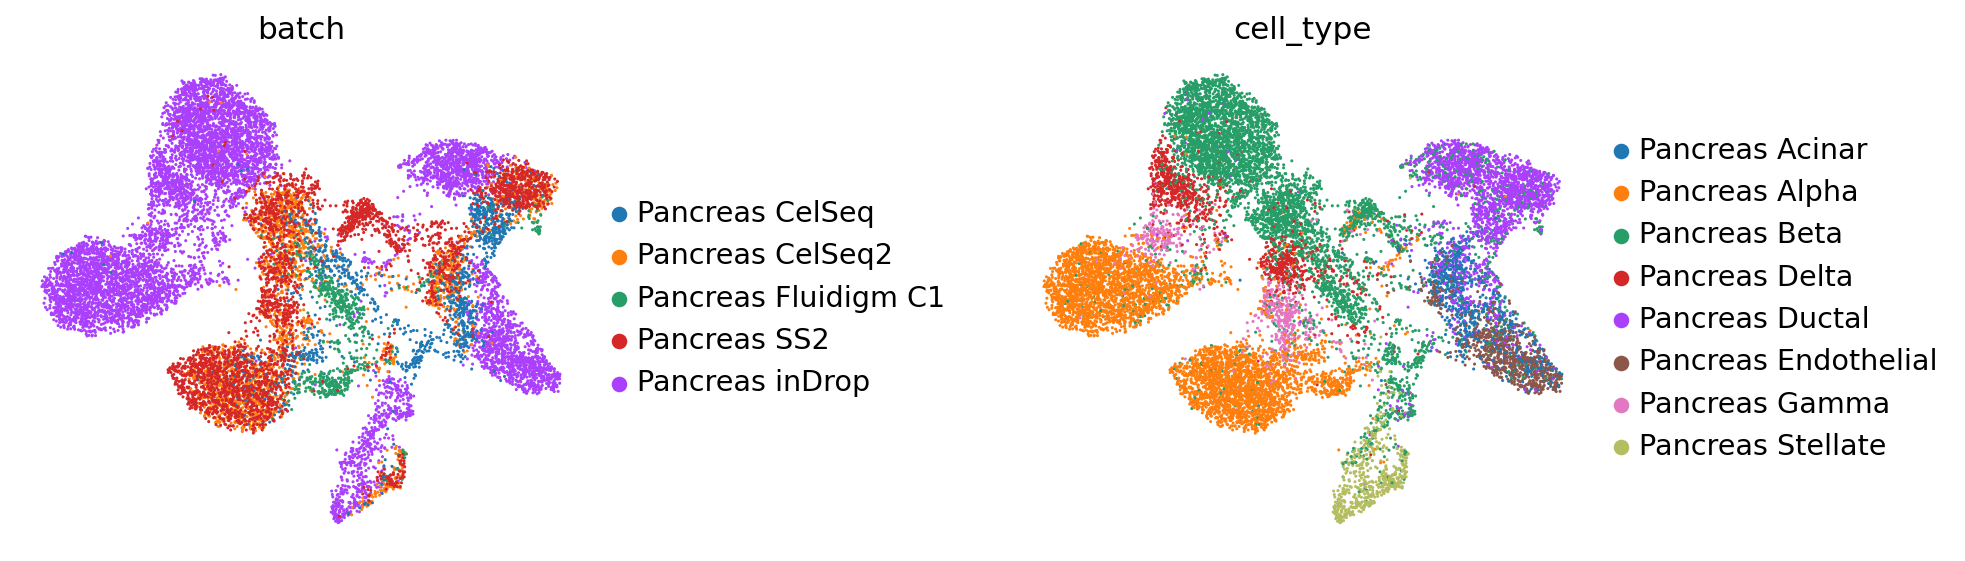

In [19]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [20]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:59:13


In [21]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_LR_1=scib.metrics.graph_connectivity(full_latent, 'batch')
Batch_corr_graph_conn_LR_1

0.9525413804706051

In [22]:
sc.tl.umap(full_latent)
Batch_corr_ASW_LR_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_LR_1

mean silhouette per group:                       silhouette_score
group                                 
Pancreas Acinar               0.669274
Pancreas Alpha                0.588750
Pancreas Beta                 0.669651
Pancreas Delta                0.527597
Pancreas Ductal               0.772131
Pancreas Endothelial          0.632139
Pancreas Gamma                0.591719
Pancreas Stellate             0.780028


0.6539111201049619

In [23]:
Bio_cons_ASW_LR_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_LR_1

0.5299279093742371

In [24]:
isolated_labels_LR_1=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_LR_1

isolated labels: no more than 5 batches per label


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Acinar: 0.5074954296160878


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Alpha: 0.6451522379682896


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Beta: 0.7450788365488199


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Delta: 0.5513307984790874


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Ductal: 0.8346456692913388


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Endothelial: 0.7280949689089882


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Gamma: 0.5345622119815668


/home/mohammed/anaconda3/envs/scarches-cl/lib/python3.7/site-packages/scib/metrics/isolated_labels.py:110: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  inplace=True,


Pancreas Stellate: 0.9038785834738617


0.6812798420335051

In [25]:
pcr_LR_1=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_LR_1

0.02870146673652502